In [128]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.graph import KGraphPreproc
from utils.evaluation import CWQ_Dataset
import networkx as nx
import ast

In [12]:
fbkb_graph = KGraphPreproc.get_fbkb_graph()

In [9]:
def get_path_len(row):
    for start in row.topic_ids:
        for target in row.answer_ids:
            try:
                if nx.has_path(fbkb_graph._graph, start, target):
                    return nx.shortest_path_length(fbkb_graph._graph, start, target)
            except nx.NodeNotFound:
                continue
    return -1

In [15]:
cwq_eval = CWQ_Dataset()

In [46]:
cwq_tset = cwq_eval.test_set.copy()
cwq_tset["hops"] = cwq_tset.apply(get_path_len, axis=1)

In [100]:
# load model answers
for r_set in cwq_eval.result_set_paths:
    set_name = r_set.split("/")[-1].split(".")[0]
    cwq_tset["Actual"] = cwq_eval.answers
    result_df = pd.read_csv(r_set, dtype=str, index_col=0)
    result_df.rename(columns={1: "Model"}, inplace=True)
    cwq_tset[set_name] = result_df.Model.apply(lambda s: str(s).lower().split(","))
    # print(cwq_tset)
    cwq_tset[f"{set_name}_rouge-l"] = cwq_tset.apply(lambda t: cwq_eval.get_rouge_score_for_answers(t.Actual, t[set_name]), axis=1)
    cwq_tset[f"{set_name}_correct"] = cwq_tset.apply(lambda t: t[f"{set_name}_rouge-l"] >= 0.5, axis=1)
cwq_tset.head()

,ID,compositionality_type,question,answers,topic_ids,answer_ids,hops,Actual,bline,bline_rouge-l,...,kb3_correct,sbert-kb1,sbert-kb1_rouge-l,sbert-kb1_correct,sbert-kb2,sbert-kb2_rouge-l,sbert-kb2_correct,sbert-kb3,sbert-kb3_rouge-l,sbert-kb3_correct
894,WebQTest-1311_e920e31a99d6b7dfbeef110668d3103d,comparative,What inspiration of Antoni Gaudi died later th...,"[{'aliases': ['W. Morris'], 'answer': 'William...","[/m/0g84t93, /m/0g84t93, /m/0g84t93, /m/0g84t9...",[/m/08304],5,[william morri],"[park güell, sagrada família, casa batlló, ...",0.0,...,False,"[park guell, sagrada familia, none of the pr...",0.0,False,"[park güell, sagrada família, casa batlló, ...",0.0,False,"[park guell, sagrada familia, none of the pr...",0.0,False
1329,WebQTest-1382_b9b879060be6df6cb7cd937a7996f9d9,comparative,What country borders Argentina and has an army...,"[{'aliases': ['Brazilian ', 'República Federat...","[/m/0g84t93, /m/0g84t93, /m/02lw5z, /m/0g84t93...",[/m/015fr],5,[brazil],"[brazil, chile]",1.0,...,True,[brazil],1.0,True,[brazil],1.0,True,[brazil],1.0,True
1235,WebQTest-1382_edc19b9010b39a6a7a1e3926399c8522,comparative,What country bordering Argentina has populatio...,"[{'aliases': ['Republic of Chile'], 'answer': ...","[/m/0g84t93, /m/0g84t93, /m/02lw5z, /m/0g84t93...","[/m/01p1v, /m/0165v, /m/05v10, /m/015fr, /m/07...",5,"[brazil, paraguay, bolivia, chile, uruguay]","[bolivia, paraguay, uruguay, chile]",1.0,...,True,"[paraguay, bolivia]",1.0,True,"[paraguay, bolivia, uruguay, guyana, surin...",1.0,True,"[paraguay, bolivia, uruguay, guyana, surin...",1.0,True
1778,WebQTrn-3252_34f533dd75026e91fc9acd350e6eeffb,comparative,What countries in which the Niger River flows ...,"[{'aliases': [], 'answer': 'Benin', 'answer_id...","[/m/0g84t93, /m/0g84t93, /m/02lw5z, /m/0g84t93...",[/m/0164v],6,[benin],"[mali, guinea, nigeria]",0.0,...,False,"[burkina_faso, benin, niger, mali, guinea,...",1.0,True,"[benin, niger, nigeria, chad, cameroon, g...",1.0,True,"[benin, niger, nigeria, cameroon, chad, b...",1.0,True
1471,WebQTrn-2177_dec2523c78124e170c353878876cff1e,comparative,"Where did Caroline Kennedy attend university, ...","[{'aliases': ['Harvard University, main campus...","[/m/0g84t93, /m/0g84t93, /m/02lw5z, /m/0g84t93...","[/m/03ksy, /m/01mpwj, /m/01n951]",5,"[harvard colleg, columbia law school, harvard ...",[radcliffe college (1879) and yale university ...,0.0,...,False,[radcliffe college (1879) and yale university ...,0.0,False,[radcliffe college (1879) and yale university ...,0.0,False,[radcliffe college (1879) and yale university ...,0.0,False


In [117]:
set_names = [r.split("/")[-1].split(".")[0] for r in cwq_eval.result_set_paths]
set_names

['bline',
 'kb-path',
 'kb1',
 'kb2',
 'kb3',
 'sbert-kb1',
 'sbert-kb2',
 'sbert-kb3']

In [137]:
cwq_res = cwq_tset[["hops", "compositionality_type",*[s+"_correct" for s in set_names]]]
cwq_res.head()

,hops,compositionality_type,bline_correct,kb-path_correct,kb1_correct,kb2_correct,kb3_correct,sbert-kb1_correct,sbert-kb2_correct,sbert-kb3_correct
894,5,comparative,False,False,False,False,False,False,False,False
1329,5,comparative,True,True,True,True,True,True,True,True
1235,5,comparative,True,True,True,True,True,True,True,True
1778,6,comparative,False,True,False,False,False,True,True,True
1471,5,comparative,False,True,False,False,False,False,False,False


In [139]:
hop_stats = cwq_res.groupby(by="compositionality_type").sum()
hop_stats["total"] = cwq_res.groupby(by="compositionality_type").apply(lambda t: len(t))
for rset in set_names:
    hop_stats[f"{rset}_p"] = round(hop_stats[f"{rset}_correct"] / hop_stats["total"], 3)
hop_stats

/tmp/ipykernel_3387/2302849785.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hop_stats["total"] = cwq_res.groupby(by="compositionality_type").apply(lambda t: len(t))


,hops,bline_correct,kb-path_correct,kb1_correct,kb2_correct,kb3_correct,sbert-kb1_correct,sbert-kb2_correct,sbert-kb3_correct,total,bline_p,kb-path_p,kb1_p,kb2_p,kb3_p,sbert-kb1_p,sbert-kb2_p,sbert-kb3_p
compositionality_type,,,,,,,,,,,,,,,,,,
comparative,518,50,71,43,45,43,43,45,45,100,0.500,0.710,0.430,0.450,0.430,0.430,0.450,0.450
composition,1982,154,245,137,146,142,108,91,93,400,0.385,0.612,0.342,0.365,0.355,0.270,0.228,0.232
conjunction,1988,148,252,146,138,142,126,128,126,400,0.370,0.630,0.365,0.345,0.355,0.315,0.320,0.315
superlative,509,30,68,20,22,20,19,20,24,100,0.300,0.680,0.200,0.220,0.200,0.190,0.200,0.240


In [125]:
print("CWQ")
data = hop_stats[["total", *[s+"_p" for s in set_names]]]
data

CWQ


,total,bline_p,kb-path_p,kb1_p,kb2_p,kb3_p,sbert-kb1_p,sbert-kb2_p,sbert-kb3_p
hops,,,,,,,,,
4,113,0.398,0.487,0.398,0.434,0.407,0.327,0.301,0.292
5,779,0.370,0.664,0.330,0.330,0.327,0.282,0.271,0.275
6,106,0.462,0.604,0.415,0.425,0.434,0.368,0.368,0.387
7,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
def get_n_data(data, delta=0):
    return [
        data.loc[hop, f"kb{int(hop)+delta}_p"]
        for hop in data.index
    ]

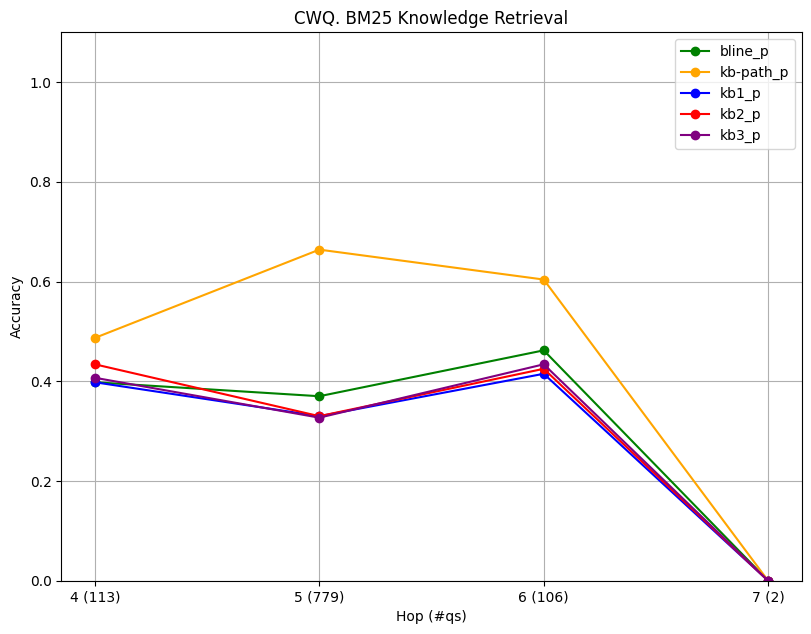

In [121]:
colors = {
    "bline_p": "green",
    "kb-path_p": "orange",
    "kb1_p": "blue",
    "kb2_p": "red",
    "kb3_p": "purple",
    # "kb4_p": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
    # "n-1": "blue",
    # "n": "red",
    # "n+1": "purple",
}

fig, ax = plt.subplots(figsize=(8, 6))

datas = {
    "bline_p": data["bline_p"].values,
    "kb-path_p": data["kb-path_p"].values,
    "kb1_p": data["kb1_p"],
    "kb2_p": data["kb2_p"],
    "kb3_p": data["kb3_p"],
}
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])

ax.set_ylim(0, 1.1)
plt.tight_layout(pad=1)
plt.title("CWQ. BM25 Knowledge Retrieval")
plt.xlabel("Hop (#qs)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Display the plot
plt.show()


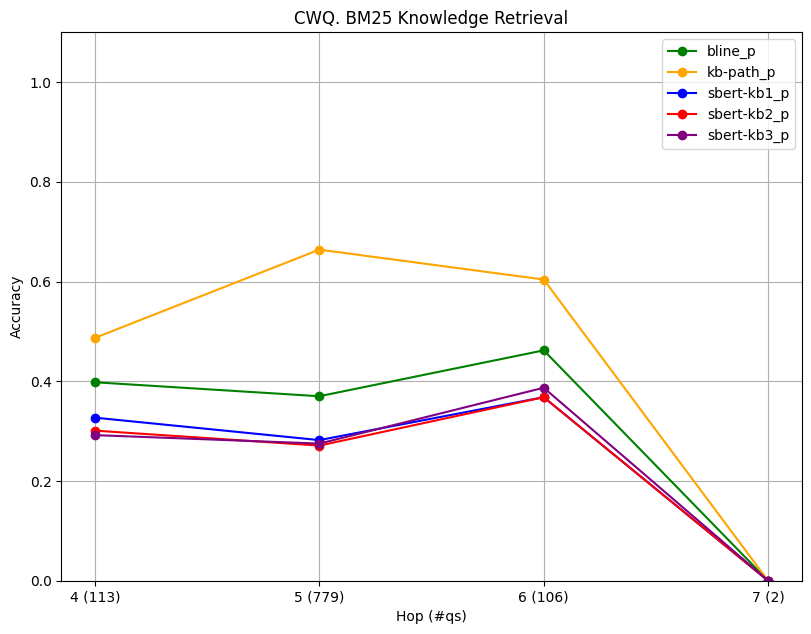

In [130]:
colors = {
    "bline_p": "green",
    "kb-path_p": "orange",
    "kb1_p": "blue",
    "kb2_p": "red",
    "kb3_p": "purple",
    "sbert-kb1_p": "blue",
    "sbert-kb2_p": "red",
    "sbert-kb3_p": "purple",
    "sbert-kb4_p": "brown",
    # "kb4_p": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
    # "n-1": "blue",
    # "n": "red",
    # "n+1": "purple",
}

fig, ax = plt.subplots(figsize=(8, 6))

datas = {
    "bline_p": data["bline_p"].values,
    "kb-path_p": data["kb-path_p"].values,
    # "kb1_p": data["kb1_p"],
    # "kb2_p": data["kb2_p"],
    # "kb3_p": data["kb3_p"],
    "sbert-kb1_p": data["sbert-kb1_p"],
    "sbert-kb2_p": data["sbert-kb2_p"],
    "sbert-kb3_p": data["sbert-kb3_p"],
}
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])

ax.set_ylim(0, 1.1)
plt.tight_layout(pad=1)
plt.title("CWQ. BM25 Knowledge Retrieval")
plt.xlabel("Hop (#qs)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Display the plot
plt.show()


### Breakdown by question type

In [133]:
cwq_res

,hops,bline_correct,kb-path_correct,kb1_correct,kb2_correct,kb3_correct,sbert-kb1_correct,sbert-kb2_correct,sbert-kb3_correct
894,5,False,False,False,False,False,False,False,False
1329,5,True,True,True,True,True,True,True,True
1235,5,True,True,True,True,True,True,True,True
1778,6,False,True,False,False,False,True,True,True
1471,5,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
2898,5,False,True,False,False,False,False,False,False
3254,5,False,False,False,False,False,False,False,False
1901,5,False,False,False,False,False,False,False,False
2507,5,False,True,False,False,False,False,False,False
